## Apply label smoothing (with Ground Truth) to infoNCE 

In [19]:
import torch
import torch.nn.functional as F
import os
from src.utils import *
import numpy as np
import matplotlib.pyplot as plt
import argparse
# from src.gaussian import Gaussian
# from src.mix_gaussian import MixedGaussian
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [20]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

In [21]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=10, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-20, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--alpha", type=float, default=1e-4, help="smooth parameter")

parser.add_argument("--reg", type=int, default=1, help="if apply regularization")

parser.add_argument("--n_epoch", type=int, default=2000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=4, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.01  # moving average rate

In [22]:
continue_train = True  # set to True to continue to train
load_available = False # set to False to prevent loading previous results
overwrite = False  # set to True to overwrite previously stored results

In [23]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

In [24]:
def GT(x, y):
    mi = -0.5 * np.log(1 - opt.rho**2) * opt.d
    c = opt.rho / (2 * (1 - opt.rho**2))
    return mi + c * (2 * x * y - opt.rho *(x**2 + y**2)).sum(dim=1)


def GT_prob(x, y):
    """
    return the probability P(1|X,Y)
    """
    return GT(x, y).exp() / (1+ GT(x, y).exp())

In [25]:
name = f'./results/Smoothed_InfoNCE_GT_dim{opt.d}'   # filename
chkpt_name = name+'.pt'      # checkpoint

from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/Smoothed_InfoNCE_GT_dim{opt.d}_reg{opt.reg}/{TIMESTAMP}')

discriminator = Net(input_size=opt.d*2, hidden_size=100)

In [26]:
if cuda:
    discriminator.cuda()

# Adam optimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [27]:
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [28]:
def smooth_loss(net, model, x_data, y_data, writer=None, epoch=None, reg=False):
    # alpha: float p(C=0)/p(C=1)
    # net: torch.nn.Module
    # model: sklearn.tree.DecisionTreeClassifier
    # return: loss of smoothed infoNCE
    # first term:
    # E[f(X,Y)*p(C=1|X,Y)] + alpha*E[f(X',Y')*p(C=1|X',Y')]
    joint_samples = torch.cat((x_data, y_data), dim=1)
    x_tile = x_data.unsqueeze(0).repeat((x_data.shape[0], 1, 1))
    y_tile = y_data.unsqueeze(1).repeat((1, x_data.shape[0], 1))
    train_data = torch.cat([x_tile, y_tile], dim = -1).reshape(-1, x_data.shape[1]+y_data.shape[1])
    train_label = torch.eye(x_data.shape[0]).reshape(-1,)
   
    marginal_samples = train_data[train_label==0,:]
    prob_DT = model(train_data[:,:opt.d], train_data[:,opt.d:]).reshape(-1,1)
    pos_prob_DT = torch.Tensor(prob_DT)[train_label==1,:]
    neg_prob_DT = torch.Tensor(prob_DT)[train_label==0,:]

    a = (net(joint_samples)*pos_prob_DT).mean() + (net(marginal_samples)*neg_prob_DT).mean()
    # second term:
    # E[log (E[e^f(X,Y')*p(C=0|X,Y')/p(C=0|X)*P(C=0)|X] + E[e^f(X,Y)*p(C=0|X,Y)/p(C=0|X)*p(C=1)|X])]

    # b_list contains log (E[e^f(X,Y')*p(C=0|X,Y')/p(C=0|X)*P(C=0)|X] + E[e^f(X,Y)*p(C=0|X,Y)/p(C=0|X)*p(C=1)|X]) for each x
    b_list = []
    for i in range(x_data.shape[0]):
        x_i = x_data[i,:]
        y_i = y_data[i,:]
        batch_label = torch.zeros(x_data.shape[0])
        batch_label[i] = 1
        x_tile = x_i.unsqueeze(0).repeat((x_data.shape[0], 1))
        batch_xy = torch.cat([x_tile, y_data], dim = 1)

        batch_xy_ = torch.cat((batch_xy[batch_label==1].repeat((batch_xy.shape[0]-1, 1)), batch_xy[batch_label==0]), dim=0)

        # P(C=0|x) = E[P(C=0|x,Y')]
        pcx = (1-model(batch_xy_[:,:opt.d],batch_xy_[:,opt.d:])).mean()


        b_list.append(torch.logsumexp(net(batch_xy_)+torch.log((1-model(batch_xy_[:,:opt.d],batch_xy_[:,opt.d:])).reshape(-1,1)), dim=0) - np.log(batch_xy_.shape[0]) - torch.log(pcx))
    if writer is not None:
        writer.add_scalar('a', a, epoch)
        writer.add_scalar('b', torch.mean(torch.stack(b_list)), epoch)

    if reg:
        return a - sum(b_list)/len(b_list) - (sum(b_list)/len(b_list))**2
    else:
        return a - sum(b_list)/len(b_list)

In [29]:
# continue_train = False  # set to True to continue to train
if continue_train:
    _iter = 0
    for i in range(opt.n_epoch):
        idx = torch.randperm(opt.sample_size)
        idx_X, idx_Y = randerange(opt.sample_size)
        for j in range(opt.n_iters_1epoch):
            batch_idx = idx[j::opt.n_iters_1epoch]
            batch_X = X[batch_idx]
            batch_Y = Y[batch_idx]
 
            optimizer_D.zero_grad()
            loss = - smooth_loss(discriminator, GT_prob, batch_X, batch_Y, reg=opt.reg) # negative infonce_bound as the loss
            # print(loss)
            loss.backward()

            optimizer_D.step()


        with torch.no_grad():
            mi_est = smooth_loss(discriminator, GT_prob, X, Y, writer, _iter)
        mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), _iter)
        writer.add_scalar('loss', loss, _iter)
        _iter += 1
        if _iter%200==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(_iter, loss.item(), mi_est))
            fig = plot_fig(discriminator, X, Y, opt.d)
            writer.add_figure('heatmap', fig, _iter)
            writer.add_histogram('first layer', discriminator.fc[0].weight.data, _iter)
            writer.add_histogram('second layer', discriminator.fc[1].weight.data, _iter)
            writer.add_histogram('third layer', discriminator.fc[2].weight.data, _iter)

            writer.add_histogram('first layer (grad)', discriminator.fc[0].weight.grad.data, _iter)
            writer.add_histogram('second layer (grad)', discriminator.fc[1].weight.grad.data, _iter)
            writer.add_histogram('third layer (grad)', discriminator.fc[2].weight.grad.data, _iter)

writer.add_graph(discriminator, (XY,))
writer.close()

Iternation: 200, loss: -4.906795, mi_est: 4.763664
Iternation: 400, loss: -8.219025, mi_est: 7.793503
Iternation: 600, loss: -8.174212, mi_est: 8.186710
Iternation: 800, loss: -8.189706, mi_est: 8.274589
Iternation: 1000, loss: -8.523934, mi_est: 8.312264
Iternation: 1200, loss: -8.252420, mi_est: 8.331388
Iternation: 1400, loss: -8.504405, mi_est: 8.340329
Iternation: 1600, loss: -8.311644, mi_est: 8.347068
Iternation: 1800, loss: -8.492503, mi_est: 8.357012
Iternation: 2000, loss: -8.441822, mi_est: 8.365294


In [30]:
if overwrite or not os.path.exists(chkpt_name):
    model_state = discriminator.state_dict()
    torch.save({
        'mi_list': mi_list,
        'model_state': model_state
    }, chkpt_name)
    writer.close()
    print('Current results saved.')

Current results saved.


In [31]:
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

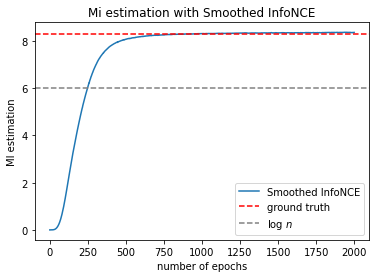

In [32]:
plt.plot(mi_list, label='Smoothed InfoNCE')

plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
# for t in range(len(mi_copy)):
#     if (mi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
plt.xlabel('number of epochs')
plt.ylabel('MI estimation')
plt.title('Mi estimation with Smoothed InfoNCE')
plt.legend()
plt.savefig(f'results/Smoothed_InfoNCE_GT_dim{opt.d}_ma{ma_rate}.pdf')